* Oskar Szudzik 148245
* Krystian Moras 148243

This is a main notebook for our second project - board game detection.

In [1]:
# %pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

In [2]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [3]:
mvideo = cv2.VideoCapture('data/dice.mp4')
if mvideo.isOpened():
    print('Video loaded')

mvideo_width = int(mvideo.get(3))
mvideo_height = int(mvideo.get(4))

print(mvideo_height, mvideo_width)

mvideo_fps = mvideo.get(cv2.CAP_PROP_FPS)
print(mvideo_fps)

Video loaded
1920 1080
29.965823788312317


Video

In [4]:
Video.from_file('data/dice.mp4')

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00isommp42\x00\x00\x00\x01mdat\x00\x00\x00\x00\x03\x83\x0c…

Example frame

In [5]:
def clusterize(frame,k):
    Z = frame.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = k
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((frame.shape))
    return res2

In [5]:
mvideo = cv2.VideoCapture('data/dice.mp4')

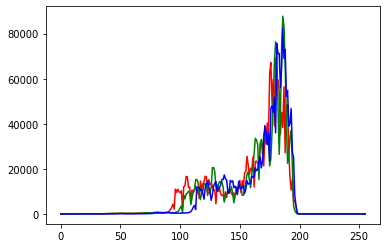

In [6]:
from matplotlib import animation
from IPython.display import clear_output
fig = plt.figure()
ax = plt.axes()

# animation function.  This is called sequentially
def animate(i):
    colors = ("red", "green", "blue")
    clear_output()
    plt.cla()
    ret, frame = mvideo.read()
    artists = []
    for i in range(3):
        histogram, bin_edges = np.histogram(frame[:, :, i], bins=256, range=(0, 256))
       # plt.plot(histogram, color=colors[i])
        artists.append(ax.plot(histogram,color=colors[i]))
    return artists

anim = animation.FuncAnimation(fig, animate, int(mvideo.get(cv2.CAP_PROP_FRAME_COUNT)))
anim.save('histogram_dice.mp4', writer = 'ffmpeg', fps = 30)

KEYPOINT DETECTION (DICE)

In [5]:
mvideo = cv2.VideoCapture('data/dice.mp4')
while(True):
    # Grab the latest image from the video feed
    ret, frame = mvideo.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret,thresholded = cv2.threshold(gray, 140, 170, cv2.THRESH_BINARY)

    # more info on setting params but imo good starting point
    params = cv2.SimpleBlobDetector_Params()
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(thresholded)
    keypoints
    im_with_keypoints = cv2.drawKeypoints(frame, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv2.imshow('frame',im_with_keypoints)

    res = cv2.waitKey(1)

    # Stop if the user presses "q"
    if res & 0xFF == ord('q'):
        break



KeyboardInterrupt: 

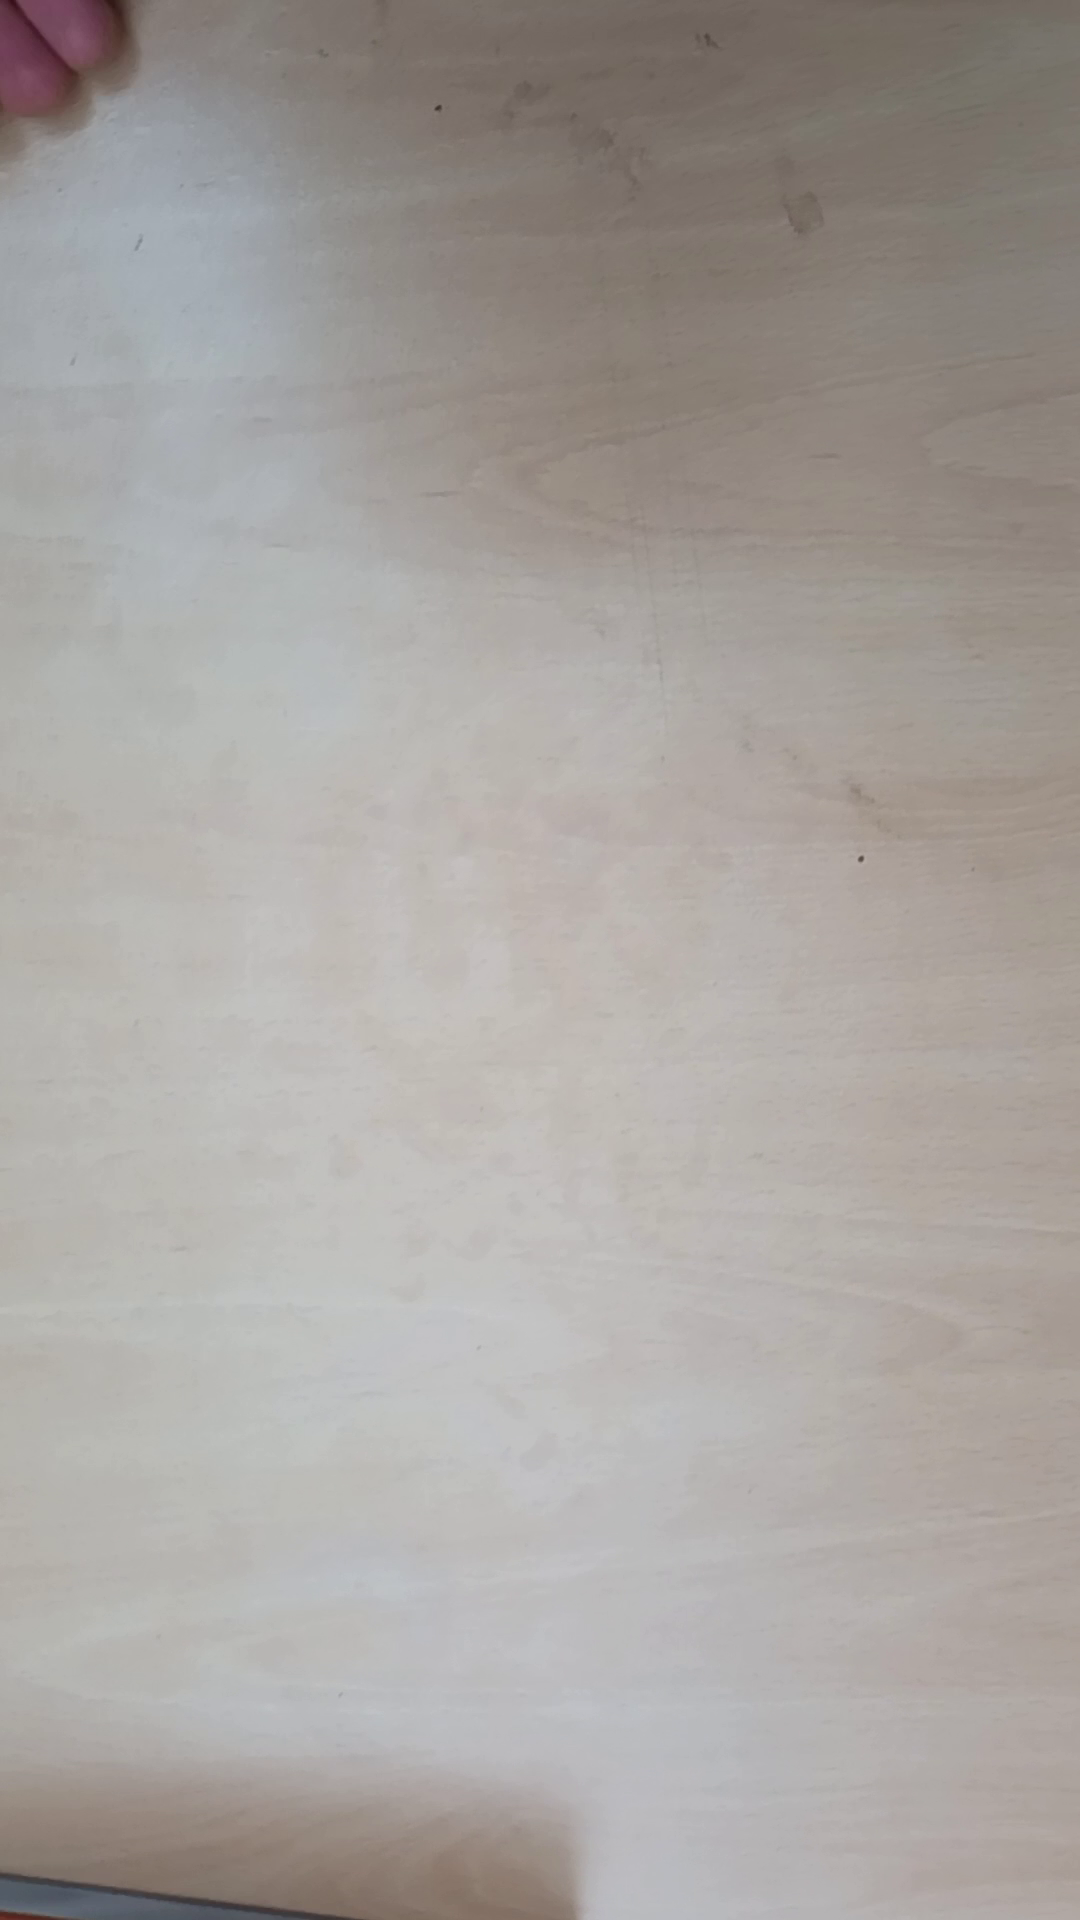

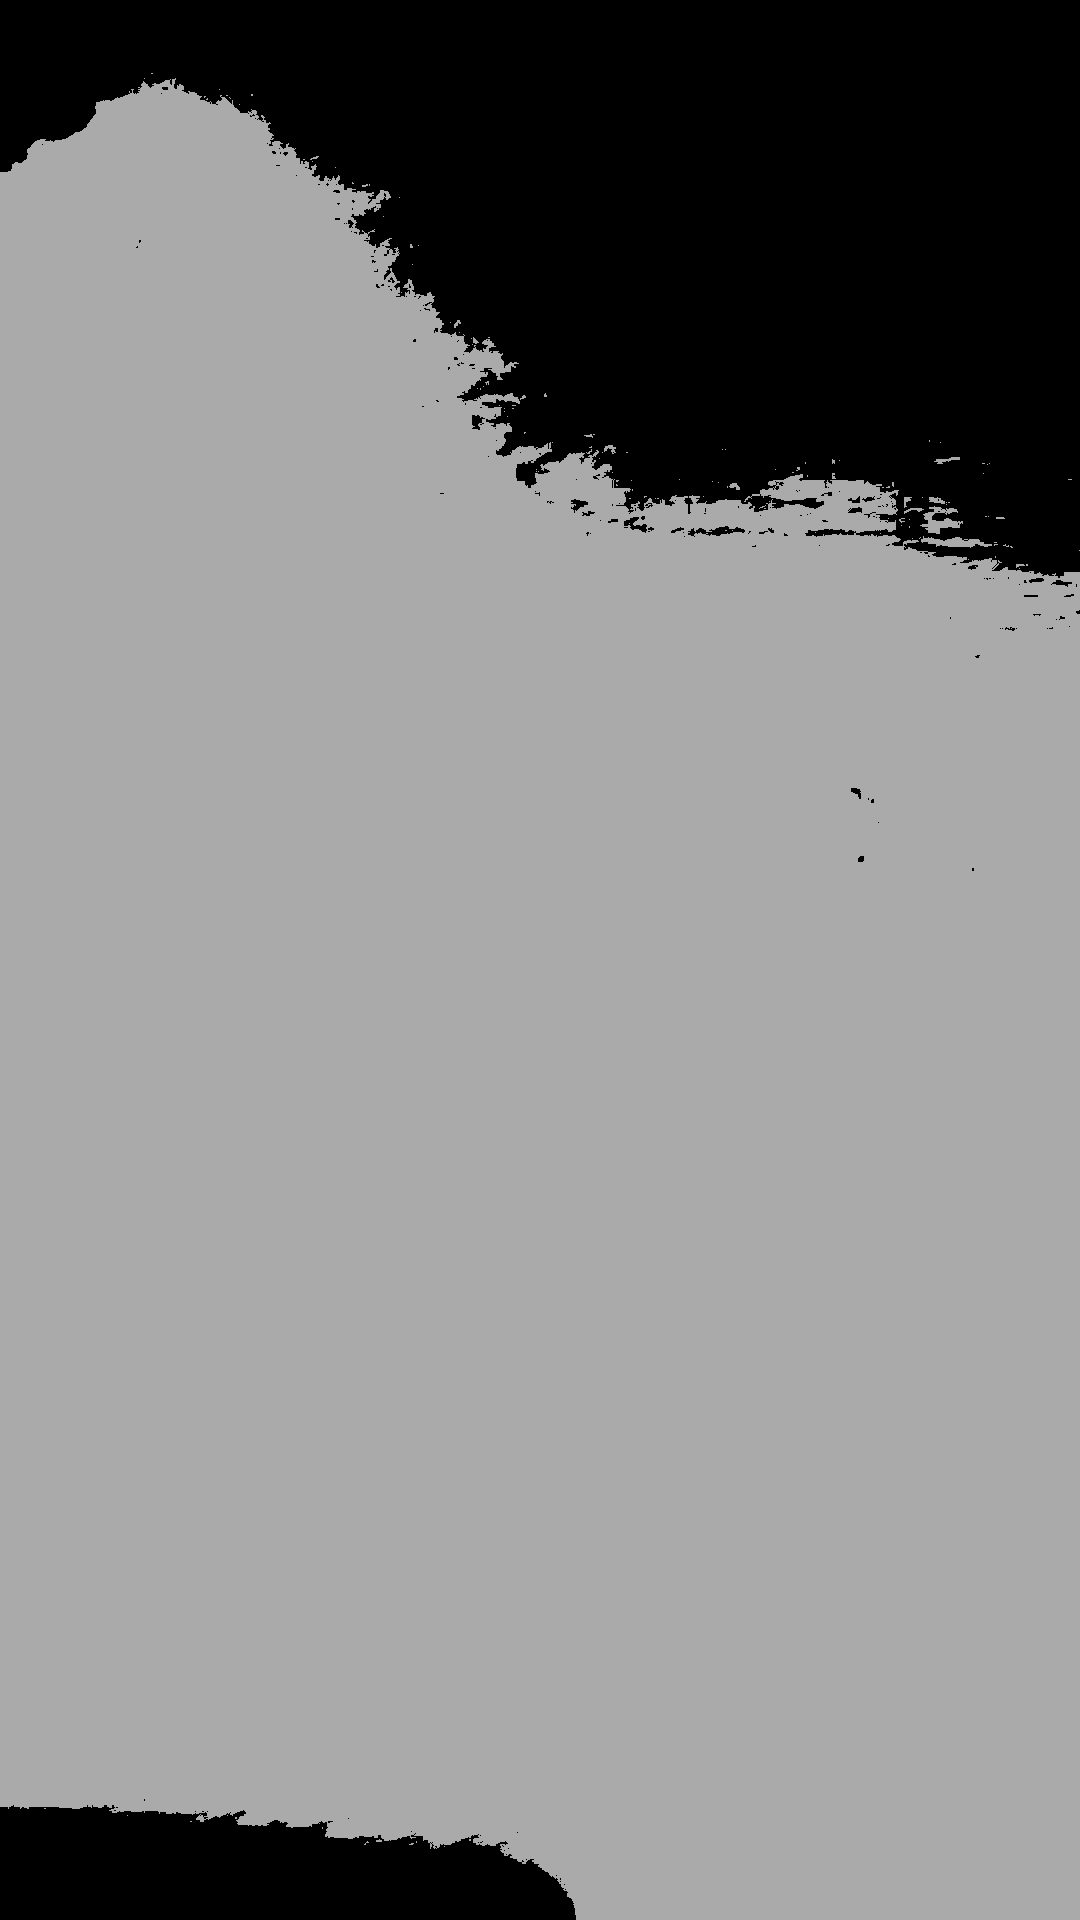

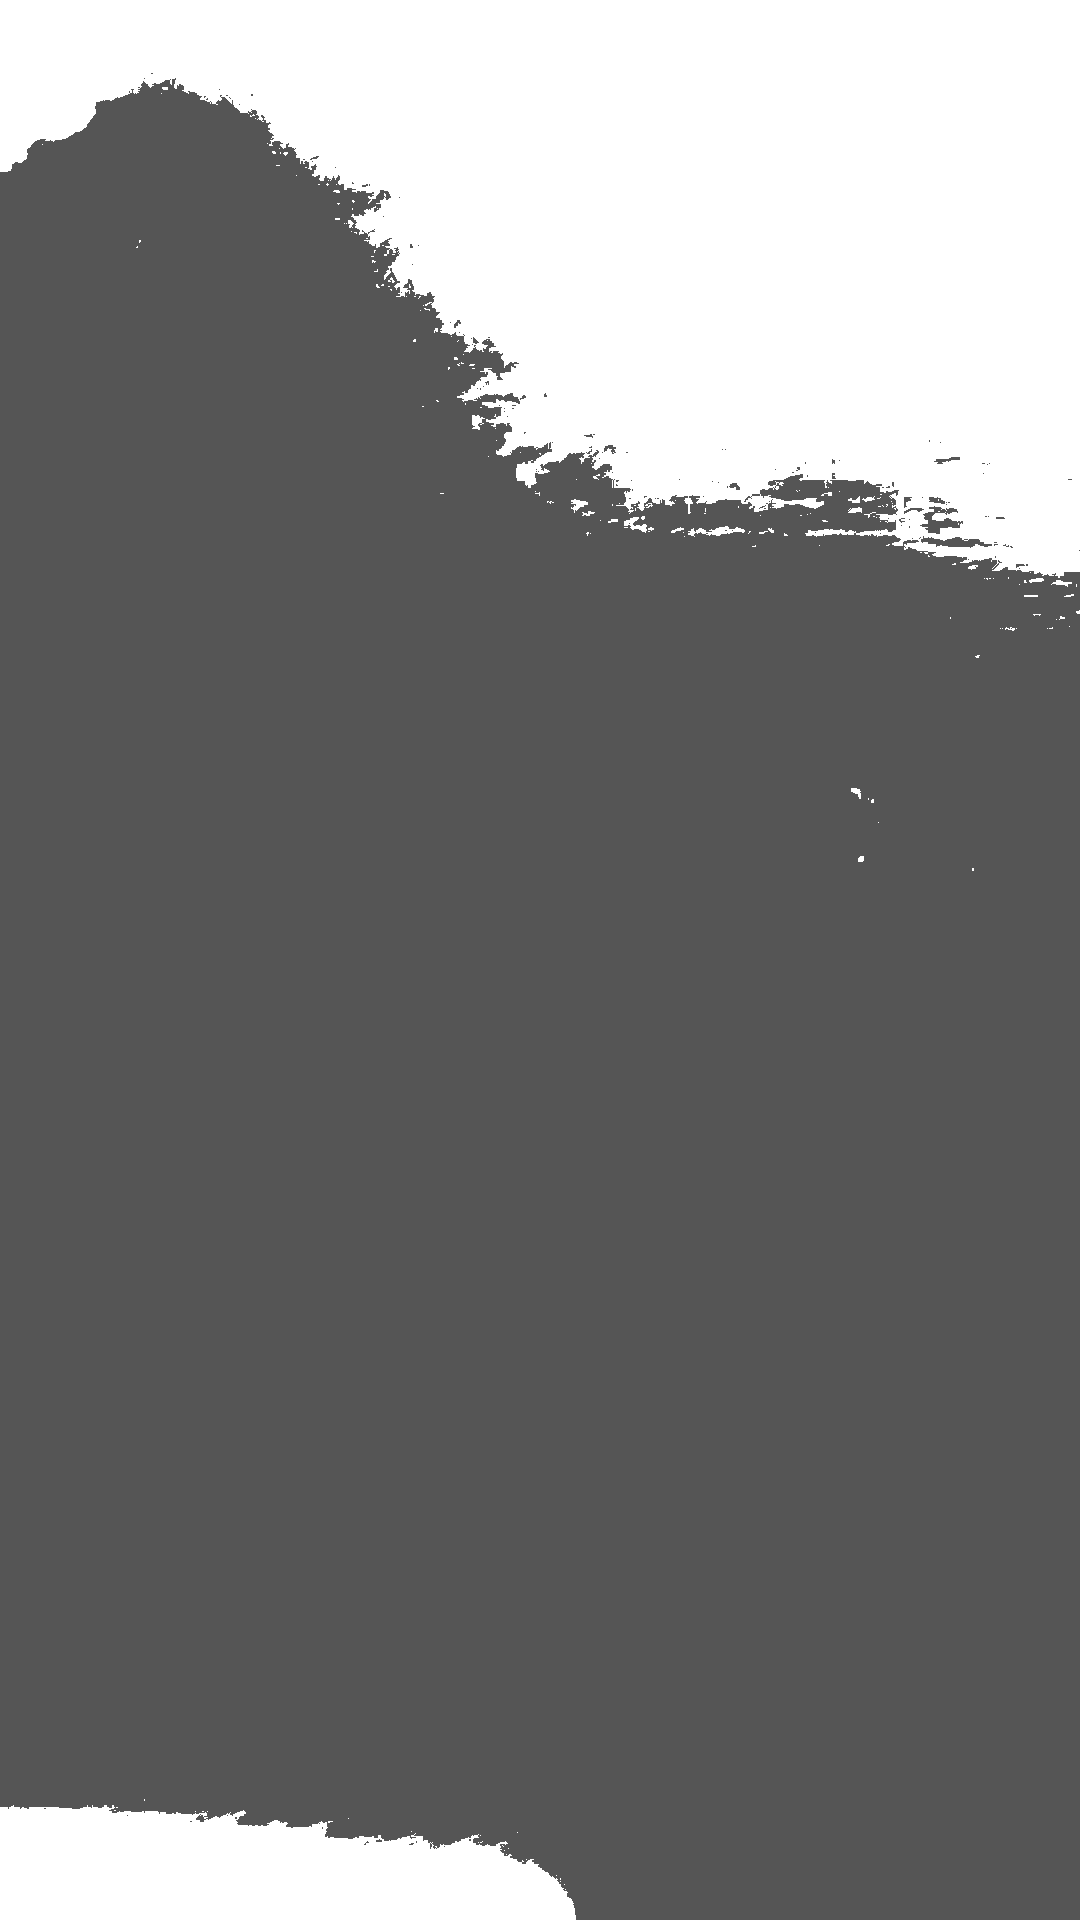

In [7]:

ret, frame = mvideo.read()
imshow(frame)


gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
ret,thresholded = cv2.threshold(gray, 140, 170, cv2.THRESH_BINARY)
imshow(thresholded)

dst = cv2.bitwise_not(thresholded)
imshow(dst)



In [8]:
params = cv2.SimpleBlobDetector_Params()
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(thresholded)
keypoints

(< cv2.KeyPoint 000001CA7FB707B0>,)

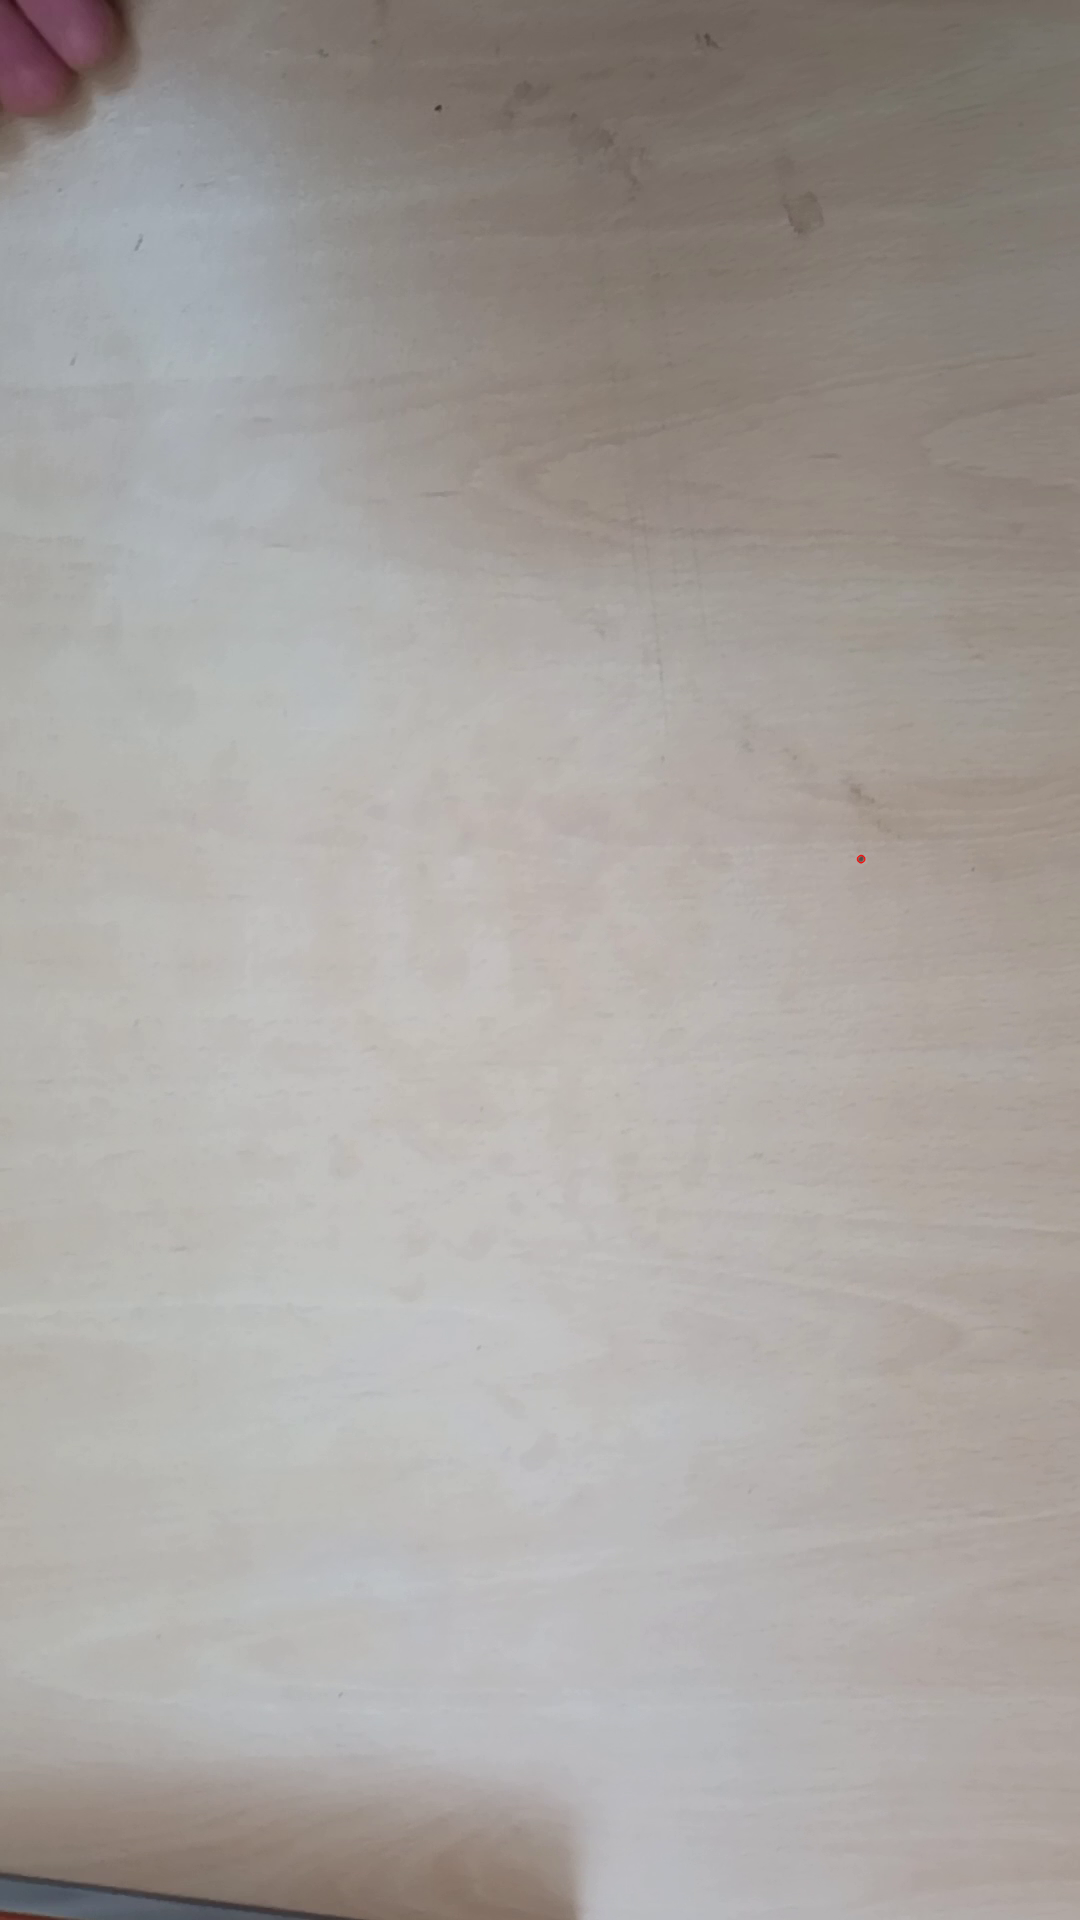

In [9]:
im_with_keypoints = cv2.drawKeypoints(frame, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

imshow(im_with_keypoints)

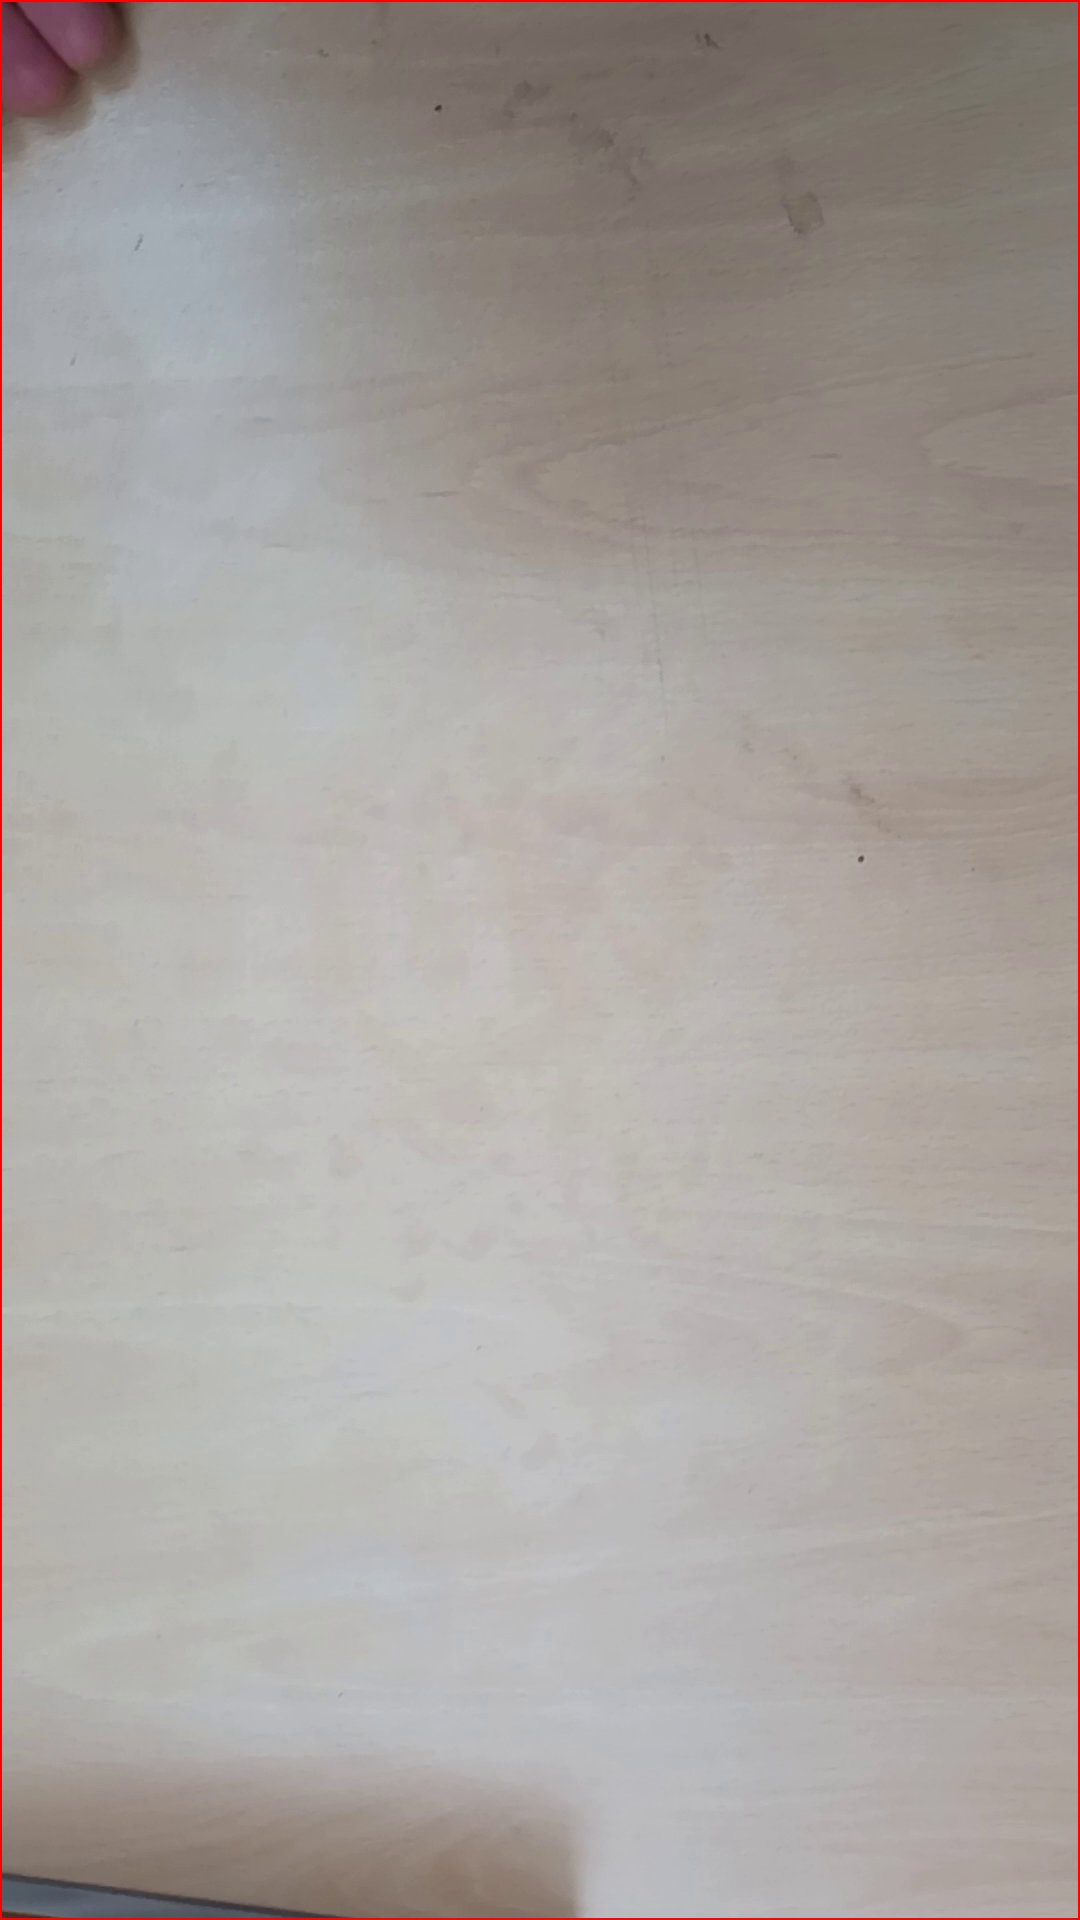

In [10]:

countours,hierarchy=cv2.findContours(dst,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# draw contours
for cnt in countours:
        cv2.drawContours(frame,[cnt],0,(0,0,255),2)
imshow(frame)

## OBJECT TRACKING - HARDCODED - TO BE DETECTED

In [3]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.TrackerCSRT_create()

def draw_bbox(frame, bbox, color=(255, 255, 255)):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame, p1, p2, color, 2, 1)

In [37]:
mvideo = cv2.VideoCapture('data/3_medium.mp4')
if mvideo.isOpened():
    print('Video loaded')

mvideo_width = int(mvideo.get(3))
mvideo_height = int(mvideo.get(4))

print(mvideo_height, mvideo_width)

mvideo_fps = mvideo.get(cv2.CAP_PROP_FPS)
print(mvideo_fps)

Video loaded
480 852
30.0


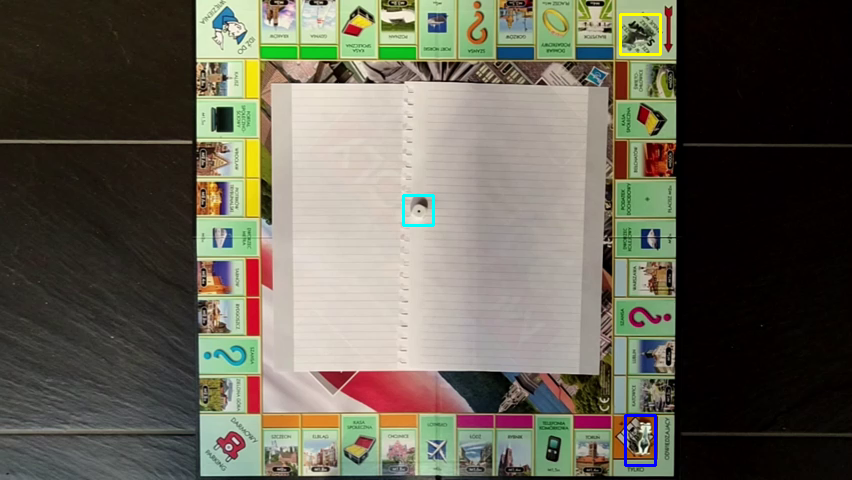

In [38]:
mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = mvideo.read()

# for easy
# player_bbox = (235, 425, 50, 50)
# dice_bbox = (253, 300, 30, 30)

# for medium
player_bbox = (625, 415, 30, 50)
player2_bbox = (620, 14, 40, 40)
dice_bbox = (403, 195, 30, 30)


draw_bbox(frame, player_bbox, (255, 0, 0))
draw_bbox(frame, player2_bbox, (0, 255, 255))
draw_bbox(frame, dice_bbox, (255, 255, 0))

imshow(frame)

In [39]:
mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = mvideo.read()

# for easy
# player_bbox = (235, 425, 50, 50)
# dice_bbox = (253, 300, 30, 30)

# for medium
player_bbox = (625, 415, 30, 50)
player2_bbox = (620, 14, 40, 40)
dice_bbox = (403, 195, 30, 30)

player_tracker = create_tracker('MIL')
player2_tracker = create_tracker('MIL')
dice_tracker = create_tracker('MIL')

if player_tracker.init(frame, player_bbox):
  print('Player tracking algorithm initiated at point:', player_bbox)

if player2_tracker.init(frame, player2_bbox):
  print('Player2 tracking algorithm initiated at point:', player2_bbox)

if dice_tracker.init(frame, dice_bbox):
  print('Dice tracking algorithm initiated at point:', dice_bbox)

mvideo_track = cv2.VideoWriter('./medium_track_' + 'MIL' + '.avi', cv2.VideoWriter_fourcc(*'DIVX'), mvideo_fps, (mvideo_width, mvideo_height))

mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)

while mvideo.isOpened():
    ret, frame = mvideo.read()

    if ret:
      ok, bbox = player_tracker.update(frame)
      if ok: draw_bbox(frame, bbox, (0, 255, 0))

      ok, bbox = player2_tracker.update(frame)
      if ok: draw_bbox(frame, bbox, (0, 255, 0))

      ok, bbox = dice_tracker.update(frame)
      if ok: draw_bbox(frame, bbox, (0, 255, 0))

      mvideo_track.write(frame)
    else:
        break

mvideo_track.release()

TO CHANGE AVI TO MP4 (enter project folder, past a following command to cmd):

In [23]:
# ffmpeg -hide_banner -loglevel error -i easy_track_MIL.avi -y easy_track_MIL.mp4
# ffmpeg -hide_banner -loglevel error -i medium_track_MIL.avi -y medium_track_MIL.mp4

### TRYING TO FIND FIELD LINES

Video loaded
480 852
30.0


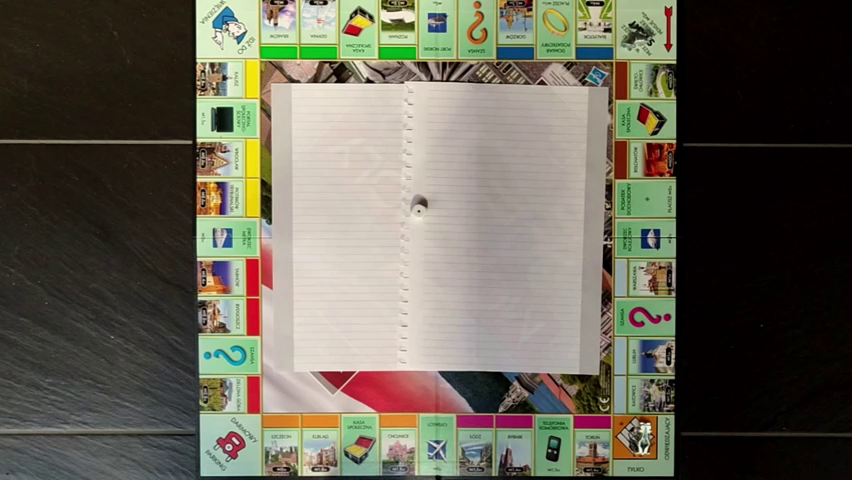

In [213]:
mvideo = cv2.VideoCapture('data/3_medium.mp4')
if mvideo.isOpened():
    print('Video loaded')

mvideo_width = int(mvideo.get(3))
mvideo_height = int(mvideo.get(4))

print(mvideo_height, mvideo_width)

mvideo_fps = mvideo.get(cv2.CAP_PROP_FPS)
print(mvideo_fps)
mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = mvideo.read()

imshow(frame)

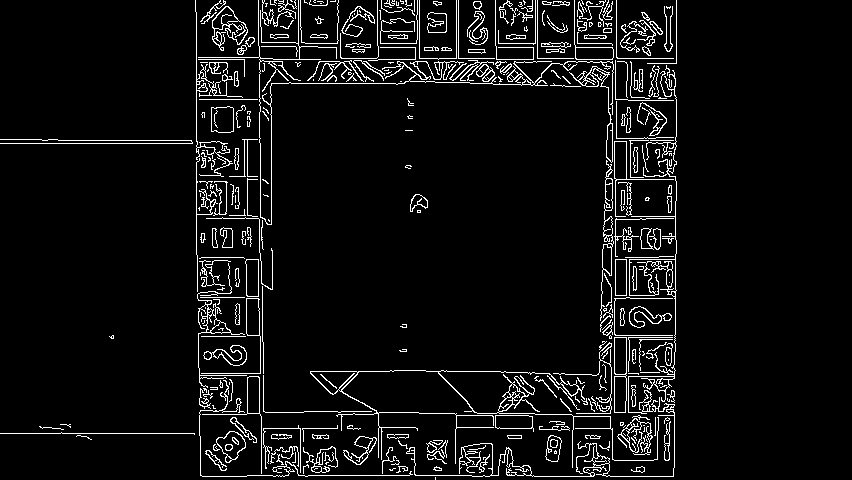

In [215]:
img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) 
result = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
imshow(result) 

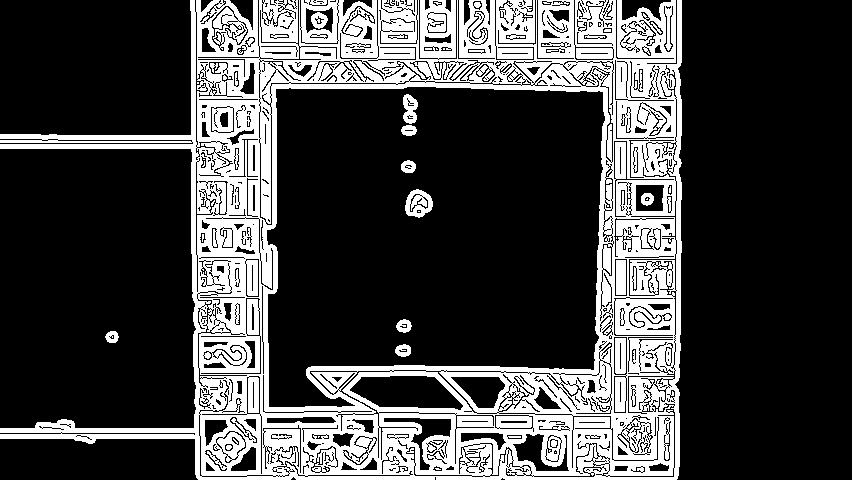

In [216]:
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 1)
adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thresh_type = cv2.THRESH_BINARY_INV
bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)
imshow(bin_img)

Lines from HoughLines algorithm - might be helpful later, but idk yet

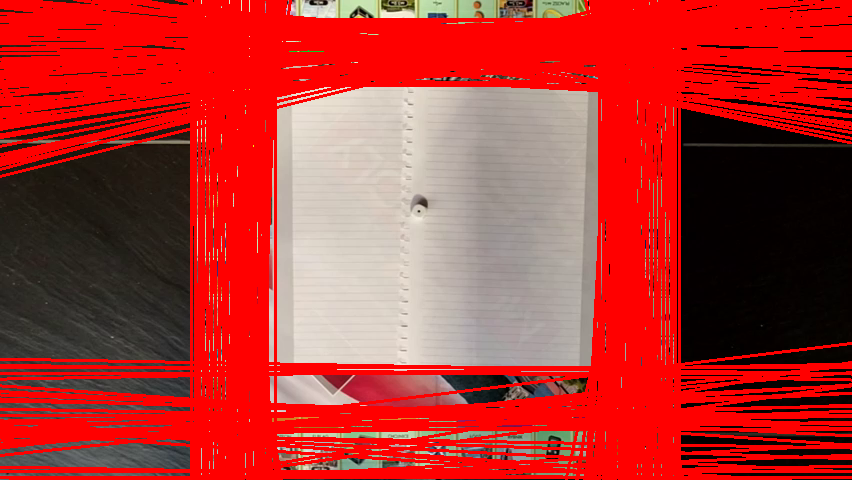

In [217]:
# rho, theta, thresh = 2, np.pi/180, 800
# lines = cv2.HoughLines(bin_img, rho, theta, thresh)
# for line in lines:
#     rho, theta = line[0]
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))
#     cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

# imshow(frame)